# Network Anomaly Detection

## Project Topic

The goal of this project is to build an accurate model for detecting and categorizing cyber attacks using the features commonly found in network logs (specifically `tcpdump`).

I will develop an unsupervised and supervised model and compare thier perfomance for this task

- Random Forest (Supervised)
- KMeans Clustering (Unsupervised)

My motivation for exploring these approaches is to determine the viability of a near real-time network attack categorization tool that can operate on a stream of logs. I want to investigate if the advantages of unsupervised models on dynamic datasets could outweigh the proven accuracy of supervised models.

## Setup

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest

warnings.filterwarnings("ignore")

plt.style.use("ggplot")
sns.set_theme(style="whitegrid")

RANDOM_STATE = 418

%matplotlib inline
%load_ext jupyter_black

## Data

This project uses a public dataset that can be found here: https://research.unsw.edu.au/projects/unsw-nb15-dataset

I'm using this slightly modified and smaller sample of the full dataset: https://www.kaggle.com/datasets/mrwellsdavid/unsw-nb15

The dataset was created by the Cyber Range Lab of the Australian Centre for Cyber Security (ACCS) and includes a mix of real modern normal activities and synthetic contemporary attack behaviours.

> Free use of the UNSW-NB15 dataset for academic research purposes is hereby granted in perpetuity. To whom intend the use of the UNSW-NB15 dataset have to cite these five papers.
> Moustafa, Nour, et al. "An Ensemble Intrusion Detection Technique based on proposed Statistical Flow Features for Protecting Network Traffic of Internet of Things." IEEE Internet of Things Journal (2018).
Koroniotis, Nickolaos, Moustafa, Nour, et al. "Towards Developing Network Forensic Mechanism for Botnet Activities in the IoT Based on Machine Learning Techniques." International Conference on Mobile Networks and Management. Springer, Cham, 2017.
Moustafa, Nour, et al. "Generalized Outlier Gaussian Mixture technique based on Automated Association Features for Simulating and Detecting Web Application Attacks." IEEE Transactions on Sustainable Computing (2018).
Keshk, Marwa, Moustafa, Nour, et al. "Privacy preservation intrusion detection technique for SCADA systems." Military Communications and Information Systems Conference (MilCIS), 2017. IEEE, 2017.
Moustafa, Nour, et al. "A New Threat Intelligence Scheme for Safeguarding Industry 4.0 Systems." IEEE Access (2018).
Moustafa, Nour, et al. "Anomaly Detection System Using Beta Mixture Models and Outlier Detection." Progress in Computing, Analytics and Networking. Springer, Singapore, 2018. 125-135.
Moustafa, Nour, et al. "Flow Aggregator Module for Analysing Network Traffic." Progress in Computing, Analytics and Networking. Springer, Singapore, 2018. 19-29.
Moustafa, Nour, et al. "A Network Forensic Scheme Using Correntropy-Variation for Attack Detection." IFIP International Conference on Digital Forensics. Springer, Cham, 2018.

In [2]:
train_data = pd.read_csv("./data/UNSW_NB15_training-set.csv")
test_data = pd.read_csv("./data/UNSW_NB15_testing-set.csv")

## Exploratory Data Analysis

This dataset is large, and has a huge number of features. I suspect we will need to investigate some feature reduction techniques.

I also check for missing values in the data, and fortunately it seems we have a complete data set. We should watch out for outliers or impossible values, but for the most part this data seems clean and reliable.

In [3]:
print(f"Number of entries: {len(train_data)}")
print(f"Number of features: {train_data.shape[1]}")

missing_values = train_data.isnull().sum()
print(f"Missing values: {missing_values.sum()}")

Number of entries: 175341
Number of features: 45
Missing values: 0


### Data Distribution Analysis

The models we will develop could solve a binary catigorization problem (`label` 0=normal, 1=attack) and a multi-class categorization problem (`attack_cat`). Let's check the distribution of these two features.

In [4]:
label_counts = train_data["label"].value_counts()
label_percentages = 100 * train_data["label"].value_counts(normalize=True)

print(
    pd.DataFrame({"Count": label_counts, "Percentage (%)": label_percentages.round(2)})
)

        Count  Percentage (%)
label                        
1      119341           68.06
0       56000           31.94


In [5]:
attack_cat_counts = train_data["attack_cat"].value_counts()
attack_cat_percentages = 100 * train_data["attack_cat"].value_counts(normalize=True)

print(
    pd.DataFrame(
        {"Count": attack_cat_counts, "Percentage (%)": attack_cat_percentages.round(2)}
    )
)

                Count  Percentage (%)
attack_cat                           
Normal          56000           31.94
Generic         40000           22.81
Exploits        33393           19.04
Fuzzers         18184           10.37
DoS             12264            6.99
Reconnaissance  10491            5.98
Analysis         2000            1.14
Backdoor         1746            1.00
Shellcode        1133            0.65
Worms             130            0.07


I'm surprised to find that this dataset has more entries of attack traffic than normal traffic. This will have to be considered when building models. Also the class distribution is very uneven so we may need to consider class weighting.

### Feature Analysis

This dataset has a lot of features, so it will take some work to understand how features interact and what features are important.

In [6]:
categorical_columns = train_data.select_dtypes(include="object").columns.tolist()
numeric_columns = [
    c
    for c in train_data.select_dtypes(include=["int64", "float64"]).columns.tolist()
    if c not in ["id", "label"]
]

print(f"Categorical features: {categorical_columns}")
print(f"Numerical features: {numeric_columns}")

Categorical features: ['proto', 'service', 'state', 'attack_cat']
Numerical features: ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']


For all the models I will need to encode the categorical features with one-hot or label encoding. I will also likely need to scale the numerical features to work well with distance based models like KMeans.

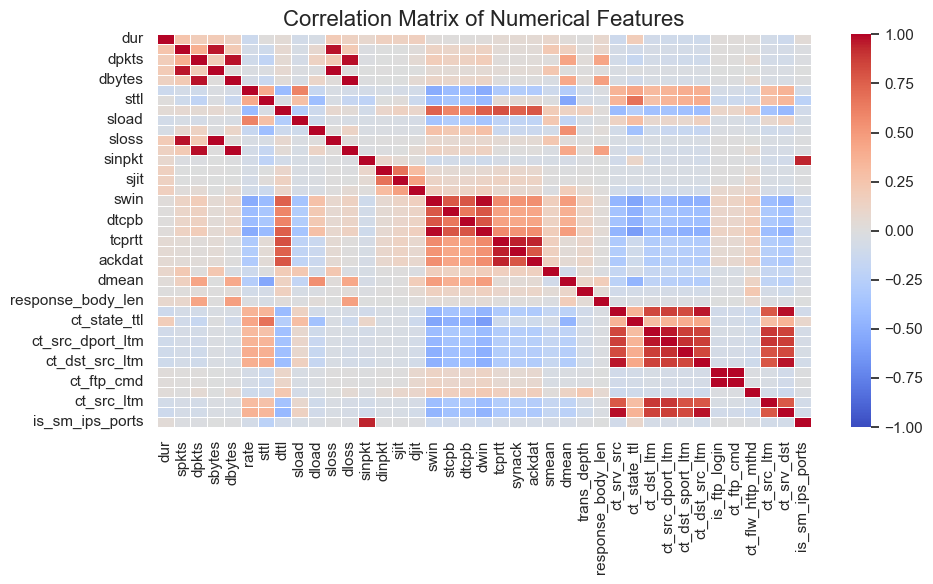

In [7]:
correlation_matrix = train_data[numeric_columns].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(
    correlation_matrix,
    annot=False,
    cmap="coolwarm",
    linewidths=0.5,
    vmin=-1,
    vmax=1,
)
plt.title("Correlation Matrix of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

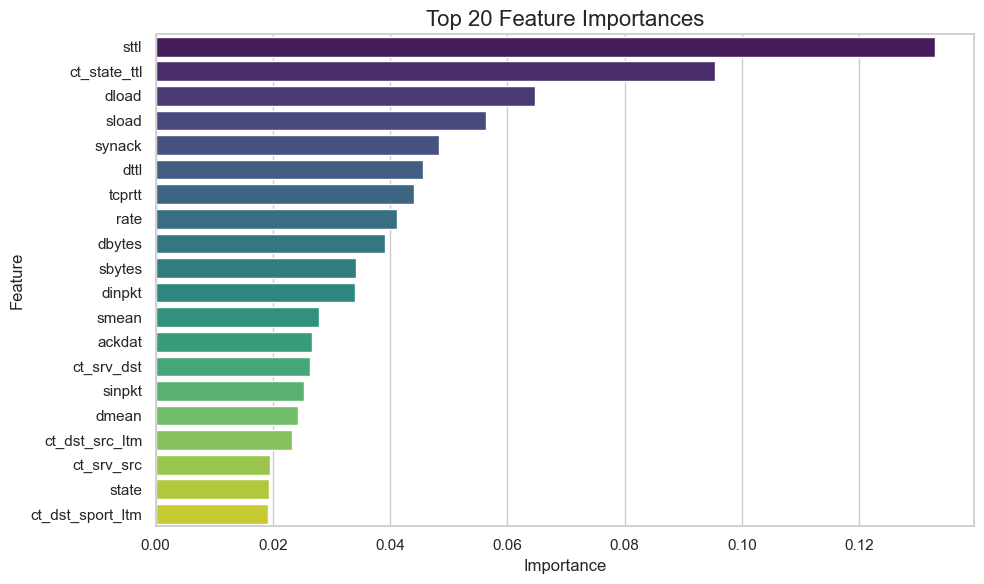

In [8]:
X_encoded = train_data.drop(["label", "attack_cat", "id"], axis=1).copy()

for column in categorical_columns:
    if column in X_encoded.columns:
        le = LabelEncoder()
        X_encoded[column] = le.fit_transform(X_encoded[column])

y = train_data["label"]
rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
rf.fit(X_encoded, y)

feature_importances = pd.DataFrame(
    {"Feature": X_encoded.columns, "Importance": rf.feature_importances_}
).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance", y="Feature", data=feature_importances.head(20), palette="viridis"
)
plt.title("Top 20 Feature Importances", fontsize=16)
plt.tight_layout()
plt.show()

From this analysis we can see that `sttl` and features highly correlated to `sttl` are very important for correctly classifying `type`.

### Dimensionality Assessment

We can explore using principle component analysis to reduce the dimensionality of our data. This would be especially helpful for the KMeans and Isolation Forest models which suffer from the curse of dimensionality, but could also help our Random Forest model.

Number of PCA components needed for 90% variance: 17


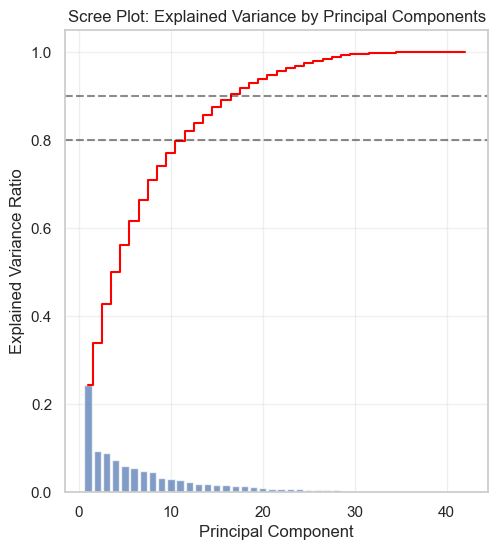

In [9]:
df = train_data.copy()

categorical_columns = ["proto", "service", "state"]
for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
features = df.drop(["id", "label", "attack_cat"], axis=1, errors="ignore")

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

pca = PCA()
pca_result = pca.fit_transform(scaled_features)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7)
plt.step(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    where="mid",
    color="red",
)
plt.axhline(y=0.8, color="k", linestyle="--", alpha=0.5)
plt.axhline(y=0.9, color="k", linestyle="--", alpha=0.5)
plt.title("Scree Plot: Explained Variance by Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(True, alpha=0.3)

n_components_90 = np.argmax(cumulative_variance >= 0.9) + 1
print(f"Number of PCA components needed for 90% variance: {n_components_90}")

### Data Cleaning

From the results of EDA we can prepare the data and create data cleaning pipelines for our models.

In [10]:
# Get columns by type from feature analysis
categorical_columns = ["proto", "service", "state"]
numeric_columns = train_data.select_dtypes(
    include=["int64", "float64"]
).columns.tolist()
numeric_columns = [col for col in numeric_columns if col not in ["id", "label"]]

In [11]:
# Define data splits
X_train = train_data.drop(["id", "label", "attack_cat"], axis=1)
y_train_binary = train_data["label"]
y_train_multiclass = train_data["attack_cat"]

X_test = test_data.drop(["id", "label", "attack_cat"], axis=1)
y_test_binary = test_data["label"]
y_test_multiclass = test_data["attack_cat"]

In [12]:
# Create preprocessor for all models
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_columns),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_columns),
    ],
    remainder="drop",
)

# We can also use the findings of our PCA analysis
# ('pca', PCA(n_components=n_components_90, random_state=RANDOM_STATE))

## Models

### Random Forest (Supervised)

Testing a veriaty of hyperparamaters.

In [13]:
rf_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("pca", PCA(n_components=n_components_90, random_state=RANDOM_STATE)),
        (
            "classifier",
            RandomForestClassifier(
                n_jobs=-1, max_features="sqrt", random_state=RANDOM_STATE
            ),
        ),
    ]
)

param_grid = {
    "classifier__n_estimators": [50],
    "classifier__max_depth": [10],
    "classifier__min_samples_split": [5, 10],
}

random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_grid,
    n_iter=3,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring="accuracy",
    random_state=RANDOM_STATE,
)

random_search.fit(X_train, y_train_multiclass)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['dur',
                                                                                'spkts',
                                                                                'dpkts',
                                                                                'sbytes',
                                                                                'dbytes',
                                                                                'rate',
                                                                                'sttl',
                                                                                'dttl',
                                                                                'sload',
                                                                                'dload',
                                                                                'sloss',
                                                                                'dloss',
                                                                                'sinpkt',
                                                                                'dinpkt',
                                                                                'sjit',
                                                                                'djit',
                                                                                'swin',
                                                                                'stcpb',
                                                                                'dtcpb',
                                                                                'dwin',
                                                                                'tcprtt',
                                                                                'synack',
                                                                                'ackdat',
                                                                                'smean',
                                                                                'dmean',
                                                                                'trans_depth',
                                                                                'response_body_...
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['proto',
                                                                                'service',
                                                                                'state'])])),
                                             ('pca',
                                              PCA(n_components=np.int64(17),
                                                  random_state=418)),
                                             ('classifier',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=418))]),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'classifier__max_depth': [10],
                                        'classifier__min_samples_split': [5,
                                                                          10],
                                        'classifier__n_estimators': [50]},
                   random_state=418, scoring='accuracy', verbose=2)


Test set accuracy with best model: 0.6903

Test set classification report with best model:
                precision    recall  f1-score   support

      Analysis       0.00      0.00      0.00       677
      Backdoor       0.00      0.00      0.00       583
           DoS       0.94      0.01      0.02      4089
      Exploits       0.50      0.90      0.65     11132
       Fuzzers       0.23      0.71      0.35      6062
       Generic       0.99      0.96      0.98     18871
        Normal       0.99      0.60      0.75     37000
Reconnaissance       0.74      0.56      0.63      3496
     Shellcode       0.51      0.08      0.13       378
         Worms       1.00      0.02      0.04        44

      accuracy                           0.69     82332
     macro avg       0.59      0.38      0.36     82332
  weighted avg       0.84      0.69      0.70     82332



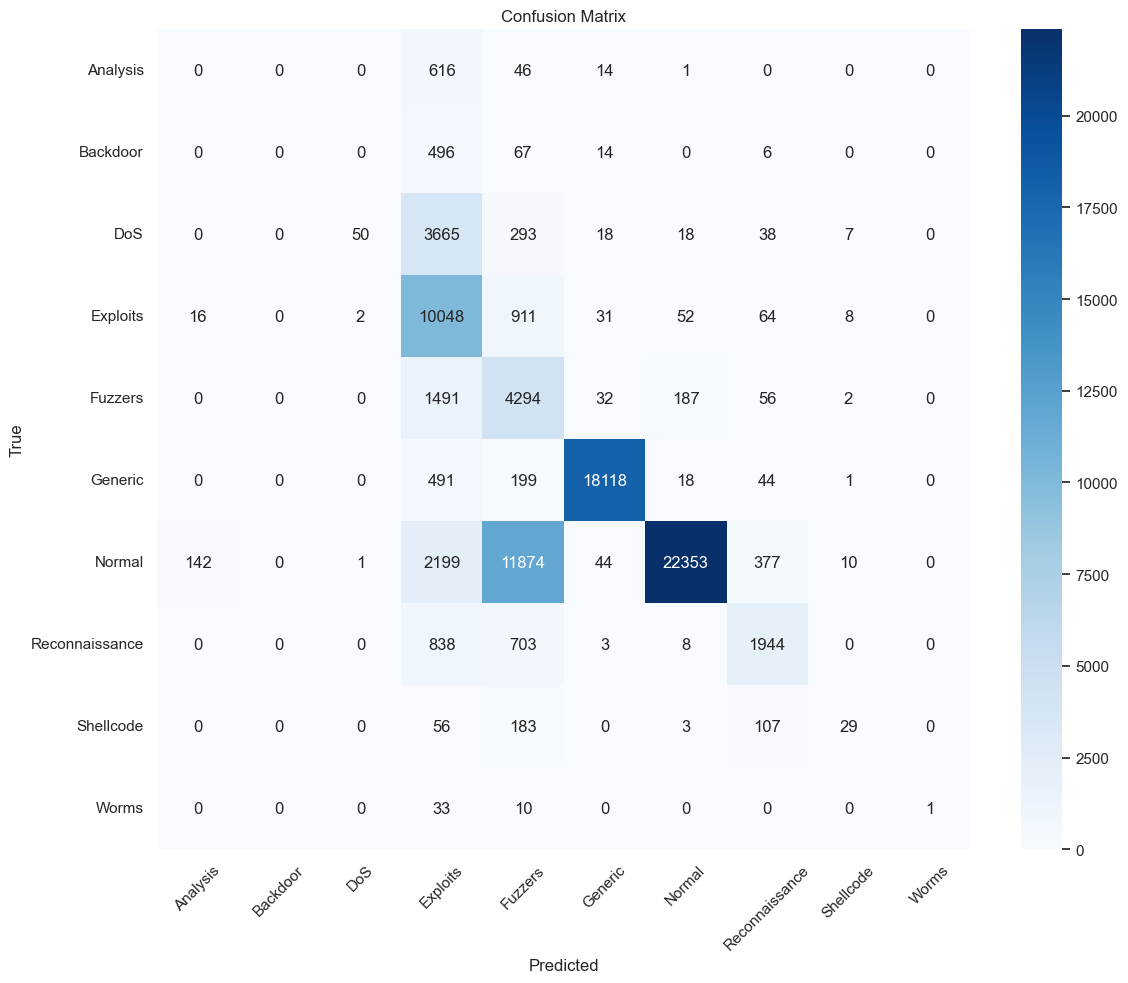

In [14]:
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print(
    "\nTest set accuracy with best model: {:.4f}".format(
        accuracy_score(y_test_multiclass, y_pred_best)
    )
)
print("\nTest set classification report with best model:")
print(classification_report(y_test_multiclass, y_pred_best))

plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test_multiclass, y_pred_best)
attack_categories = np.unique(np.concatenate([y_train_multiclass, y_test_multiclass]))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=attack_categories,
    yticklabels=attack_categories,
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### KMeans Clustering (Unsupervised)

In [15]:
n_clusters = len(y_train_multiclass.unique())
kmeans_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "pca",
            PCA(n_components=n_components_90, random_state=RANDOM_STATE),
        ),
        (
            "cluster",
            KMeans(random_state=RANDOM_STATE),
        ),
    ]
)

param_grid = {
    "cluster__n_clusters": [2, 4, 6, 8],
    "cluster__n_init": [1, 10],
    "cluster__max_iter": [100, 300],
    "cluster__algorithm": ["lloyd", "elkan"],
}


def cluster_to_label_accuracy(estimator, X, y_true):
    cluster_labels = estimator.predict(X)

    cluster_category_map = {}
    for cluster_id in np.unique(cluster_labels):
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        cluster_categories = y_true.iloc[cluster_indices]
        unique_categories, counts = np.unique(cluster_categories, return_counts=True)
        cluster_category_map[cluster_id] = unique_categories[np.argmax(counts)]

    predicted_labels = [cluster_category_map[cluster] for cluster in cluster_labels]
    return accuracy_score(y_true, predicted_labels)


random_search = RandomizedSearchCV(
    kmeans_pipeline,
    param_distributions=param_grid,
    n_iter=5,
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE,
    scoring=cluster_to_label_accuracy,
)

random_search.fit(X_train, y_train_multiclass)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['dur',
                                                                                'spkts',
                                                                                'dpkts',
                                                                                'sbytes',
                                                                                'dbytes',
                                                                                'rate',
                                                                                'sttl',
                                                                                'dttl',
                                                                                'sload',
                                                                                'dload',
                                                                                'sloss',
                                                                                'dloss',
                                                                                'sinpkt',
                                                                                'dinpkt',
                                                                                'sjit',
                                                                                'djit',
                                                                                'swin',
                                                                                'stcpb',
                                                                                'dtcpb',
                                                                                'dwin',
                                                                                'tcprtt',
                                                                                'synack',
                                                                                'ackdat',
                                                                                'smean',
                                                                                'dmean',
                                                                                'trans_depth',
                                                                                'response_body_...
                                                                                'state'])])),
                                             ('pca',
                                              PCA(n_components=np.int64(17),
                                                  random_state=418)),
                                             ('cluster',
                                              KMeans(random_state=418))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'cluster__algorithm': ['lloyd',
                                                               'elkan'],
                                        'cluster__max_iter': [100, 300],
                                        'cluster__n_clusters': [2, 4, 6, 8],
                                        'cluster__n_init': [1, 10]},
                   random_state=418,
                   scoring=<function cluster_to_label_accuracy at 0x1154ea980>,
                   verbose=2)


Accuracy using cluster mapping: 0.5694


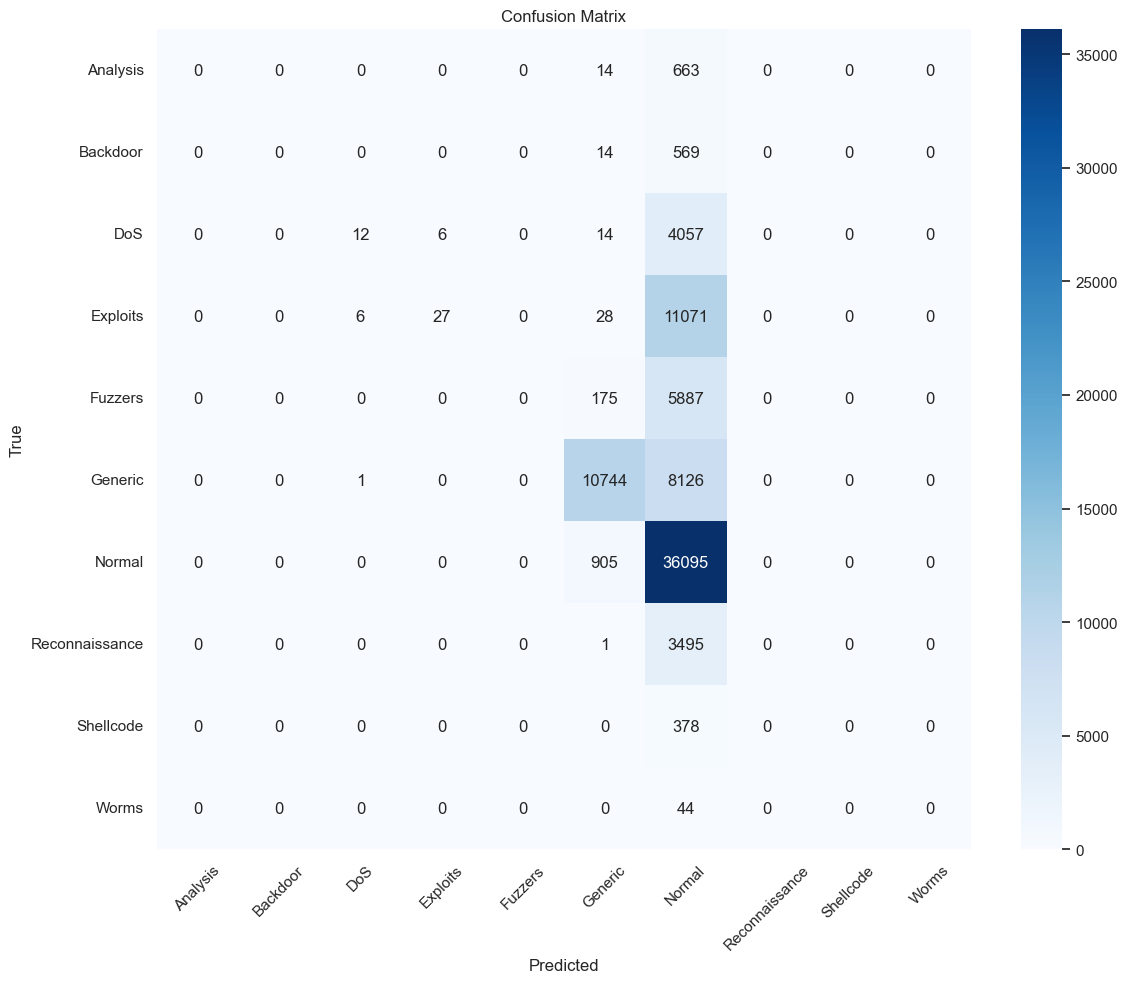

In [18]:
best_model = random_search.best_estimator_
cluster_labels = best_model.predict(X_test)

cluster_category_map = {}
for cluster_id in np.unique(cluster_labels):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    cluster_categories = y_test_multiclass.iloc[cluster_indices]
    unique_categories, counts = np.unique(cluster_categories, return_counts=True)
    cluster_category_map[cluster_id] = unique_categories[np.argmax(counts)]

predicted_categories = [cluster_category_map[cluster] for cluster in cluster_labels]

accuracy = accuracy_score(y_test_multiclass, predicted_categories)
print(f"\nAccuracy using cluster mapping: {accuracy:.4f}")

cm = confusion_matrix(y_test_multiclass, predicted_categories)
attack_categories = np.unique(np.concatenate([y_train_multiclass, y_test_multiclass]))

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=attack_categories,
    yticklabels=attack_categories,
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Conclusions

Developing an accurate unsupervised model on this dataset turned out to be challenging. While I was able to achieve performance gains looking at the natural clustering of the data, I was not able to get the model's accuracy very high compared to the supervised approach.

I would need more time to tune the model, which rules out my original plan of having the model train as new data comes in, so for this problem in general, I would recommend a supervised approach.

The principal component analysis step of my EDA raised the accuracy of both models substantially, indicating that both these models struggle with high-dimensionality data.

As a future effort, I would like to learn how to better classify the very rare attack types like `Shellcode` and `Worm`.